# TUTORIAL 1: Compare Neuron Activations Between Pairs of Images

*(Estimated read time: 8-10 minutes)* -- Not including optional footnotes

*(Estimated time to understand code: 10-30 minutes)* -- Optional

Neural Network Interpretability has been extensively studied to bring light into how neural networks make their decisions. This has important applications in understanding **why** a neural network decides a certain medical treatment, or recommends certain financial advice, which is crucial to avoid blindly trusting an AI system. 

One approach to Neural Network Interpretability aims to find patterns in neural network activations based on inputs with varying similarities. This field has found evidence that certain neurons will likely be activated for certain features. Not only that, but neurons will play "roles" in an assembly web of decision making, much like gates in a circuit. Based on these observations, we will thoroughly test hypotheses about common neural network activation patterns, starting with simple approaches that we will gradually build upon into more sophisticated approaches. <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1).

[image comparing activations]

Examples of links to existing literature in this field are given below:

<a href="https://distill.pub/2020/circuits/">Previous work done by others on interpretable neural circuits</a>

<a href="https://baulab.info/">Previous work done by others on interpreting neuron roles and network dissection</a>






---

**Our Investigation**

We hypothesize that two similar images will have similar activations. To test this, we will first compare an image and variations of its "occlussions", which black out patches of the image at various locations. We will then compare these to other images. We expect that the image and its occluded variations will have more similar activations than the image with other images. 

This is because we hypothesize that since certain neurons will likely be activated for certain features, so since similar images have similar features, the neurons that pick up on those similar features will be highly activated in both cases. In contrast, images that don't share similar features will not have neurons that highly activate for the same features. 

[image]

This is, of course, an oversimplification, due to some of the many reasons being:

- A feature may be detected by separate neurons. A nose may be detected by neuron 1, but not neuron 2, because neuron 1 only detects long noses, while neuron 2 only detects short noses
- A neuron may be 'polysemantic'- that is, it detects for multiple, unrelated features, or play multiple "roles". For example, a neuron may detect for both lions and windows. Or it may detect for a lion, AND also play the role of activating when neuron A  in the previous layer was high but neuron B in the previous layer was low.

We will ignore these oversimplifcations for now as we are merely using this as a starting point before more complex experiments.

We will proceed as follows:

For a given layer, we compare the neuron activations between two images. We will start by ranking the neurons (by index number) that have the highest activation value. We look at only the top neurons of a certain ranking threshold, such as the top 1000 neurons. 

We begin by loading the Inception V1 model and a dataset. The Inception V1 model is a convolutional neural network whose neurons' interpretability has been extensively studied <a name="cite_ref-r1"></a>[<sup>[r1]</sup>](#cite_note-r1). We'll use the Animal Image Dataset from Kaggle:

https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals



---

How to use a Colab notebook:

- The notebook has already been run, so the results are already shown without re-running. A user may run the code again for their own investigations.
- Click the arrow on the left of each code box to run the code. Or in the menu bar on top, click 'Runtime' and select 'Run All' to run all code consecutively at once
- The table of contents and loaded files can be found on the left pane of the notebook
- Click on the arrow next to each section's title to collapse that section

# Load Model

We will be using PyTorch. This is a pre-trained model.

In [ ]:
%%capture
import torch
import torchvision.models as models
from torchvision import transforms  # used for preprocessing images
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np
import os, copy

model = models.googlenet(pretrained=True)  #w/o arg, this will not pretrain it
model.eval() #set model in eval mode: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch

# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


# Load Dataset

Getting a dataset from kaggle requires a user's kaggle.json file, so we obtain it from our github repo. This will also obtain non-dataset images we will be using in our tutorial. 

(Loading the data may take up to 1 min.)

In [ ]:
%%capture
!git clone https://github.com/wlg1/analogous_neuron_circuit_expms.git

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/analogous_neuron_circuit_expms/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals
! unzip animal-image-dataset-90-different-animals.zip

data_dir = 'animals/animals'
f = open("name of the animals.txt", "r")
animals_list = f.readlines()
animals_list = [x.replace('\n','') for x in animals_list]

# Get Output Probabilities

We use these functions to obtain the output probabilities and their class labels.

In [ ]:
def get_output(model, input_image):
    # input_image = Image.open(input)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    return output
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # print(output[0])  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.

def output_probs(model, input_image):
    output = get_output(model, input_image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

def get_top_categories(probabilities, categories):
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())

def compare_probs(probs1, probs2, categories):
    top5_prob, top5_catid = torch.topk(probs1, 5)
    new_top5_prob, new_top5_catid = torch.topk(probs2, 5)
    for i in range(new_top5_prob.size(0)):
        row = ['before:', categories[top5_catid[i]], round(top5_prob[i].item(), 5), 'after:', categories[new_top5_catid[i]], round(new_top5_prob[i].item(), 5)]
        print("{: >10} {: >15} {: >10} {: >10} {: >15} {: >10}".format(*row))


# Get Activations

To compare the activations in a layer for two images, we need to get the activations that occur when passing an image through our model. For this, we will use the code below.

In [ ]:
def get_activations(input_image, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    output = model(input_batch)
    return activation.copy()  #.copy(), else will return the same actvs of model

In [ ]:
named_layers = dict(model.named_modules())
layers = list(named_layers.keys())

# too many branches, so just get the converged branch points
# '' is first layer, the input, so disregard it
layers = [x for x in layers if '.' not in x and x != '']  
layers

['conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'dropout',
 'fc']

Inception V1 has an intricate architecture consisting of Inception modules each containing of multiple branches, each with their own convolutional and pooling layers. Additionally, each convolutional layer has multiple filters of varying sizes. To simplify our tutorial, we will look at the "filter concatenation" layer of each module, which coalesces the other convolutional layers' filters.

(For more about this, see:
https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)

Let's compare using layer 'inception5a'. This is because the first few layers of Inception V1 mostly detect for edges and other low level features, which are not enough to find similar higher level features, which are hypothesized to be the "key markers" used to determine the class probabilities of an image.

In [ ]:
sample_dir = data_dir + '/antelope'
sample1_filename = os.listdir(sample_dir)[0]  #get the first image of the antelope class
sample1_filepath = os.path.join(sample_dir, sample1_filename)
input_image_1 = Image.open(sample1_filepath)

layer = layers[-5]  # 'inception5a'

actv_layer_1 = get_activations(input_image_1, layer) #a dict of layername : tensor of actvs
actv_layer_1[layer].shape

torch.Size([1, 832, 7, 7])



Though we can now get the activation values of neurons for a given image and layer, before comparing the top activation values of a layer for two images, we must solve one other issue regarding memory first. 

# Rank Top Neurons in a Layer



Note that each layer's neurons are organized in a multidimensional tensor, containing several filters of varying sizes. To rank all the neurons in a layer by activation value, we flatten this tensor to a 1D array. This is done by taking the first row of the first filter, then concatenating the second row, and so forth until the last row; then the first row of the second filter is concatenated, and so forth. Each neuron ID corresponds to the neuron's position in this 1D array.

In [ ]:
top_neurons_dict = {}

# flatten activation tensor and sort from lowest to highest
def get_sorted_neurons(input_image, layer, filename):
    actv_layer = get_activations(input_image, layer)
    flat_layer = torch.flatten(actv_layer[layer])
    sorted, indices = torch.sort(flat_layer)
    top_neurons_dict[(filename, layer)] = indices.tolist()
    return indices.tolist()

When we are comparing the same activations for several pairs of images, such as (antelope 1 VS badger 1) and (antelope 1 vs badger 2), etc, we would have to calculate the same layers of activations for an image (such as antelope 1) by passing the same image through the model multiple times, which would be redundant and take up a lot of time.

To avoid redundant computations, each time we calculate an image's layers of activations, we memoize by storing them in the dictionary 'top_neurons_dict', and calling them when we need to use them.

In [ ]:
sorted_neurons_1 = get_sorted_neurons(input_image_1, layer, sample1_filename)
sorted_neurons_1[-10:]  #the top 10 most highly activated neurons in the layer

[27164, 27163, 27162, 8054, 20530, 21755, 30379, 27929, 15532, 10896]

## Rank Top Neurons - Antelope VS Antelope w/o head

We can finally compare the top activations of a layer between images. Let's begin by comparing an image with one of its "occlusions". An occlusion is an image where some part of the image has been hidden. Occlusion experiments have been extensively used for feature importance by gradually removing certain features in the input image then analyzing their effect on model performance. [cite] 

Let's look at the image of an antelope VS the same image with the head occluded, and compare their output probabilities when they're passed through Inception V1.

In [ ]:
filepath = '/content/analogous_neuron_circuit_expms/_images/antelope occlusions/'

sample1_filename = filepath + '3a3ea34fb6.jpg'
sample2_filename = filepath + '3a3ea34fb6 - no head.jpg'

img_antelope = Image.open(sample1_filename)
img_antelope_noHead = Image.open(sample2_filename)

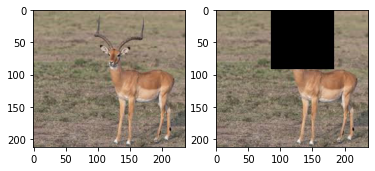

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

img_A = mpimg.imread(sample1_filename)
img_B = mpimg.imread(sample2_filename)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

In [ ]:
probs_orig = output_probs(model, img_antelope)
probs_noHead = output_probs(model, img_antelope_noHead)
compare_probs(probs_orig, probs_noHead, categories)

   before:          impala     0.5928     after:          impala    0.23008
   before:         gazelle    0.31573     after:         gazelle    0.19803
   before:      hartebeest    0.01517     after:      hartebeest    0.07879
   before:            ibex    0.00114     after:          sorrel    0.02666
   before:         bustard    0.00101     after:          Saluki    0.00871


Interestingly enough, to the closest class that the model was trained on (as it was not trained on an antelope class), the model is still able to correctly classify the image with the head removed, albeit with much lower probability. Now, let's look at how their top 10 neurons compare in layer 'inception5a':

In [ ]:
sorted_neurons_1 = get_sorted_neurons(img_antelope, layer, sample1_filename)
sorted_neurons_1[-10:]

[16154, 14416, 14145, 27162, 27165, 18490, 27157, 27156, 27164, 27163]

In [ ]:
sorted_neurons_2 = get_sorted_neurons(img_antelope_noHead, layer, sample2_filename)
sorted_neurons_2[-10:]

[9349, 16147, 15526, 14152, 11786, 11787, 16153, 16154, 14145, 17624]

It's hard to compare two lists by just a glance of judgment that varies between readers; for a more concise, an easier to compare, and a more objective ranking, we need a similarity metric. So let's see how many top 100 neurons they have in common after intersection:

In [ ]:
len(list(set(sorted_neurons_1[-100:]).intersection(sorted_neurons_2[-100:]))) 

44

But the 'number in common' should be measured RELATIVE to the number of members in each set. Having 3 in common out of 100 doesn't mean 'similar' b/c there's so many more 'chances'. Having 3 out of 5 in common means it's very similar. 

Since both sets have the same number of members, we can divide the 'number in common' by the size of a set, but an even better metric is to divide the 'number in common' by the total number of members in both sets to determine how many they have in common relative to the number of members. This is accomplished by the [Jaccard Similarity coefficient ](https://en.wikipedia.org/wiki/Jaccard_index) (this is also called the Jaccard Index; we will refer to it as 'Jaccard Similarity').



---


An alternative metric is to use [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-1). This metric considers the fact that if neuron A appears at rank 1 in image 1, and appears at rank 100 in image 2, but appears at rank 5 in image 3, then image 1 is more similar to image 3 than to image 2 due to the distance in rankings; the Jaccard Similarity does not take this into account. However, since we found that this metric is very slow to compute, we will use Jaccard Similarity.

# Get Jaccard Similarity of Highest Activated Neurons

In [ ]:
# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

# a score for a pair of images
def get_jaccard_sim(image1, image2, layer, f, f_2, topPerc):
    if (f, layer) in top_neurons_dict:
        sorted_neurons_1 = top_neurons_dict[(f, layer)]
    else:
        sorted_neurons_1 = get_sorted_neurons(image1, layer, f)
    if (f_2, layer) in top_neurons_dict:
        sorted_neurons_2 = top_neurons_dict[(f_2, layer)]
    else:
        sorted_neurons_2 = get_sorted_neurons(image2, layer, f_2)
    topNum = round(len(sorted_neurons_1)*topPerc)
    return jaccard_similarity(sorted_neurons_1[-topNum:], sorted_neurons_2[-topNum:])

Our Jaccard Similarity function takes in the images, their filenames (to store their activations for memoization), the layer to evaluate, and a 'topPerc' percentage. The last parameter determines what percentage of the neurons ranked from lowest to highest to compare. For instance, if there are 1000 neurons in the layer, then a topPerc of 0.1 will compare the top 100 neurons in the layer. We will start with a topPerc of 0.1.

Now let's test out how Jaccard Similarity does when comparing pairs of images we expect to have similar highly activated neurons, versus pairs of neurons we expect to have dissimilar highly activated neurons.

## Between occlusions VS others

At last, we have a metric to compare between pairs of images. We expect a higher similarity score for the image and its occlusions than for the image and other images.

In [ ]:
btw_occlu_score = get_jaccard_sim(img_antelope, img_antelope_noHead, layer, sample1_filename, sample2_filename, 0.1)
print('Score b/w Occlusions: ', btw_occlu_score)

Score b/w Occlusions:  0.4312796208530806


In [ ]:
filepath = '/content/analogous_neuron_circuit_expms/_images/'
sample3_fn = filepath + 'car1.jpg'
img_car = Image.open(sample3_fn)
ante_car_score = get_jaccard_sim(img_antelope, img_car, layer, sample1_filename, sample3_fn, 0.1)
print('Score b/w Antelope and Car: ', ante_car_score)

Score b/w Antelope and Car:  0.0872


In [ ]:
anteNoHead_car_score = get_jaccard_sim(img_antelope_noHead, img_car, layer, sample2_filename, sample3_fn, 0.1)
print('Score b/w Antelope (no Head) and Car: ', anteNoHead_car_score)

Score b/w Antelope (no Head) and Car:  0.08778014941302027


As we can see, the score b/w the Antelope and Antelope (with no Head) is the highest, and the scores b/w the Antelope images with the Car image are the lowest. We will later investigate this further on more examples.

## Between two of same class VS others

We call similarity scores between images in the same class 'within-class similarity', we call similarity scores between images in different classes 'between-class similarity'.

We expect a higher similarity score for the within-class images than the between-class images.

In [ ]:
data_dir

'animals/animals'

In [ ]:
layer = 'inception5a'
sample_dir = data_dir + '/antelope'
os.listdir(sample_dir).sort()  # since image orders in the list are different each run, sort for consistency

sample1_filename = os.listdir(sample_dir)[0]
sample1_filepath = os.path.join(sample_dir, sample1_filename)
input_image_1 = Image.open(sample1_filepath)

sample2_filename = os.listdir(sample_dir)[1]
sample2_filepath = os.path.join(sample_dir, sample2_filename)
input_image_2 = Image.open(sample2_filepath)

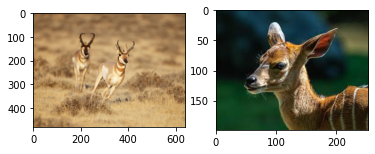

In [ ]:
img_A = mpimg.imread(sample1_filepath)
img_B = mpimg.imread(sample2_filepath)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

In [ ]:
ante1_ante2_score = get_jaccard_sim(input_image_1, input_image_2, layer, sample1_filepath, sample2_filepath, 0.1)
ante1_car_score = get_jaccard_sim(input_image_1, img_car, layer, sample1_filepath, sample3_fn, 0.1)
ante2_car_score = get_jaccard_sim(input_image_2, img_car, layer, sample2_filepath, sample3_fn, 0.1)

print('Score b/w Antelope 1 and Antelope 2: ', ante1_ante2_score)
print('Score b/w Antelope 1 and Car: ', ante1_car_score)
print('Score b/w Antelope 2 and Car: ', ante2_car_score)

Score b/w Antelope 1 and Antelope 2:  0.12577661190114595
Score b/w Antelope 1 and Car:  0.07430830039525692
Score b/w Antelope 2 and Car:  0.08763505402160865


Just like the previous section, we see that the pair of similar antelope images have a higher score than pairs of the antelope with the car image, giving evidence that the antelope images have more similar highly activated neurons with each other than with the car image.

In fact, the pair of the antelope image and the antelope with no head has a score 0.43, which is higher than the score of the pair of two different antelope images. This is consistent with our expectation that similar images have higher scores. Additionally, the scores of the antelope images with the car image are around 0.08 in all cases so far, which may imply a pattern across varying inputs we have yet to unearth. (If approximately the same number of neurons are in the top % threshold for most images, are they largely the same neurons? If so, are these 'fundamental' neurons that always activate for most images?) We will later investigate this further on more examples.

[record these questions in 'list of hypothesis to check', citing observations that led to them being considered]



## Between two of more similar classes VS of less similar classes

We call similarity scores between images in the similar class 'more-similar-class similarity', we call similarity scores between images in different classes 'less-similar-class similarity'.

We expect a higher similarity score for the more-similar-class than the less-similar-class.

First, let's find two categories that are different, yet similar. We will look at the categories in our dataset, rather than the set of classes that the model was trained on.

In [ ]:
# categories[0:5]
print(animals_list[38])
print(animals_list[-1])

horse
zebra


Clearly, 'horse' and 'zebra' are different classes that are similar, in that they are both specific members of the taxonomic family Equidae.

In [ ]:
layer = 'inception5a'

sample_dir_horse = data_dir + '/horse'
os.listdir(sample_dir_horse).sort()
horse_fn = os.listdir(sample_dir_horse)[0]
horse_fn = os.path.join(sample_dir_horse, horse_fn)
img_horse = Image.open(horse_fn)

sample_dir_zebra = data_dir + '/zebra'
os.listdir(sample_dir_zebra).sort()
zebra_fn = os.listdir(sample_dir_zebra)[1]
zebra_fn = os.path.join(sample_dir_zebra, zebra_fn)
img_zebra = Image.open(zebra_fn)

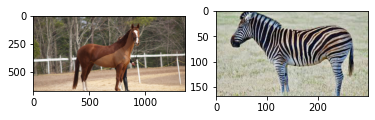

In [ ]:
img_A = mpimg.imread(horse_fn)
img_B = mpimg.imread(zebra_fn)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

In [ ]:
horse_zebra_score = get_jaccard_sim(img_horse, img_zebra, layer, horse_fn, zebra_fn, 0.1)
horse_car_score = get_jaccard_sim(img_horse, img_car, layer, horse_fn, sample3_fn, 0.1)
zebra_car_score = get_jaccard_sim(img_zebra, img_car, layer, zebra_fn, sample3_fn, 0.1)

print('Score b/w Horse and Zebra: ', horse_zebra_score)
print('Score b/w Horse and Car: ', horse_car_score)
print('Score b/w Zebra and Car: ', zebra_car_score)

Score b/w Horse and Zebra:  0.1287375415282392
Score b/w Horse and Car:  0.08502994011976048
Score b/w Zebra and Car:  0.07289473684210526


Just as expected, the pair in the more-similar-class similarity group has a higher score than the pairs in the less-similar-class similarity group; however, the score is not that much higher, compared to the comparisions in the 'occlusion' section. This is also expected, as the occlusion section analyzed pairs of images that were much more similar than a horse and a zebra.

Depending on the pair selected, this score is also less than the score some of the pairs in the 'within-class similarity' group from the previous section, which is not to be expected! However, this can be explained for several reasons, such as the model picking up on other features that are similar in the pair (for example, the image may have grass in both images, even though one is of a horse and the other is of a zebra), and the fact that horses and zebras are similar so they should share simiar highly activated neurons. Notice that in the previous section, one antelope image is far away, and the other is a close up of a head. In contrast, the horse and the zebra are both side profile images at a more comparable distance. Thus, future experiments should compare images that block out features we do not want to compare.

This brings up an important possibility: not all neurons have an equal role. Just because a neuron is highly activated than another, doesn't mean it has an important "role" than another neuron in determining whether an equine image is a horse or a zebra. Just a few neurons may be responsible for this subtle distinction.

These handful of comparisons are not enough to draw strong conclusions, so we have to look at more comparisons, and examine their statistics, such as their averages. We will be doing this in an optional 'appendix' tutorial, which can be found in the link below.
<br/><br/>
<a href="https://colab.research.google.com/drive/1Jcv2-E8YOt5d9F88Tx1CXIuQqZJxkqqx"><center><font size="+1"><b>APPENDIX TUTORIAL 1: Compare Neuron Activations Across Layers Between Categories of Images</b></font></center></a>
<br/><br/>

Or skip to the next tutorial:
<br/><br/>
<a href="https://colab.research.google.com/drive/15dQyu5t3fkFBfsp5sKe0KdPiNI6G28Rm"><center><font size="+1"><b>TUTORIAL 2: Find the previous layer neurons that contributed the most to the highest class probability</b></font></center></a>

<br/><br/>


---
---
<a name="cite_note-1"></a>1. [^](#cite_ref-1) 
Note that unless, for instance, a simple approach has been frequently used before or was the "first approach" to a problem that many have already tried before, a simple approach is still worth considering to ensure that 'no stone is left unturned', especially if those using them would not be doing anything else of importance. Simple approaches are often overlooked by people who do not have time to do them. But if there is good reason to try a simple approach, it can bring light to the importance of discoveries which were glanced over by others. 

Say there are gold nuggets, and they can be anywhere in an area with caves and forests. Since they can be inside a cavern that only investigators trained in cave exploration can explore, it is a wise investment of resources for the skilled cavern-trained investigators to spend their time exploring that cavern. But the gold nuggets may also be hidden in the grass, and it is a waste of money to hire skilled cavern-trained investigators to just look through grass, which non-cavern-trained investigators can do just as well. Thus, if there is evidence suggesting that there is a non-trivial chance for gold nuggets to be found in grass, then investigation should also be done to check the grass. Just because it is simple to check the grass, does not mean everything in it has been found, as thorough investigations can often uncover observations missed by previous ones. Even if the investigations turn up only negative results, the negative results are very important for ensuring that nothing has been left unchecked, and for ensuring that redundant investigations won't be repeated. 

Furthermore, there may be results found in the grass that can not be found by those in the caverns, such as serendipitously noting that wild squirrels native to the area are good trackers of gold nuggets. These observations would not be noted in caverns, where squirrels do not roam. Investigators in the grass can share these results to those in the caverns, thus facillitating their cavern explorations by having cave explorers bring squirrels into caverns as trackers.
<br/><br/>
<a name="cite_note-2"></a>2. [^](#cite_ref-2) Additionally, the exact order of neurons should not matter that much; rankings of "n3, n8, n9" should be similar to "n9,n8,n3", which Levenshtein distance takes into account. The Levenshtein distance, or Edit Distance, allows deletion, insertion and substitution (but no swapping; that's two substitutions).

<br/><br/>



---



---

References:

<a name="cite_note-r1"></a>r1. [^](#cite_ref-r1) Olah, et al., "Zoom In: An Introduction to Circuits", Distill, 2020.

https://distill.pub/2020/circuits/zoom-in/